## Option Pricing

In [3]:
import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

yfin.pdr_override()

# List of stock symbols
ticker = 'META'

# Set the date range for the historical data
start_date = '2020-08-01'
end_date = '2023-08-01'

# Download historical stock data for each stock

stock = pdr.get_data_yahoo(ticker, start_date, end_date)



[*********************100%***********************]  1 of 1 completed


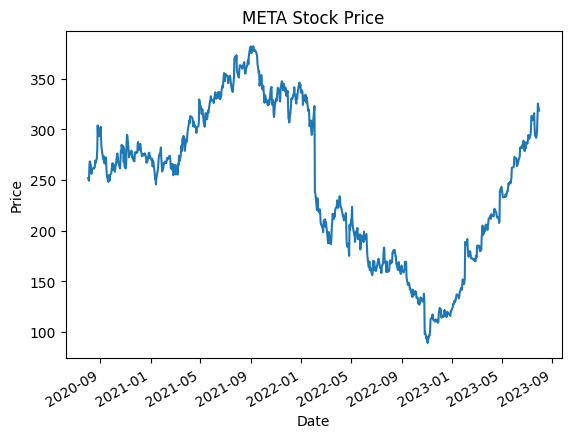

In [4]:
# Plot the stock price
stock['Close'].plot(ylabel='Price',title=f"{ticker} Stock Price")
plt.show()

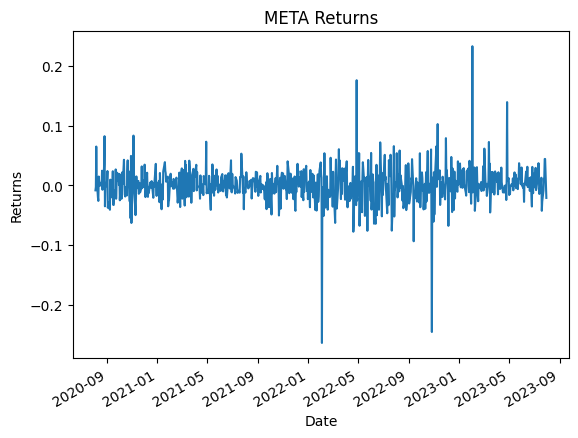

In [5]:
stock['Returns'] = stock['Close'].pct_change()


stock['Returns'].plot(ylabel='Returns',title=f"{ticker} Returns")
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller
# Testing stationarity
stat_test = adfuller(stock['Returns'].dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is not stationary")


The test statistic and p-value of ADF test are (-27.36131688520552, 0.0)
The data is stationary


### Estimating volatility

Use weighted returns to calculate the volatility from the historical data.
Exponential weighted moving average can be used get an estimate

$\sigma_{n}=(1-\lambda)\Sigma_{1}^{\inf}\lambda^{i-1}R^{2}_{n-i+1}$

Analysing with three values of $\lambda=0.85,0.9,0.95$

In [7]:
import numpy as np 

def get_volatility(returns,j,lmb):
    N=returns.shape[0]
    sig=0
    for i in range(1,N):
        sig += (lmb**(i-1))*returns[j-i+1]**2
    sig *= (1-lmb)
    return sig

stock['Returns'].fillna(0,inplace=True)

stock['EMAV85'] = 0
stock['EMAV90'] = 0
stock['EMAV95'] = 0

# vol = np.zeros(len(stock['Returns']))
for j in range(len(stock['Returns'])):
    stock['EMAV85'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.85))
    stock['EMAV90'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.90))
    stock['EMAV95'].iat[j] = np.sqrt(get_volatility(stock['Returns'].values,j,0.95))


<Axes: xlabel='Date'>

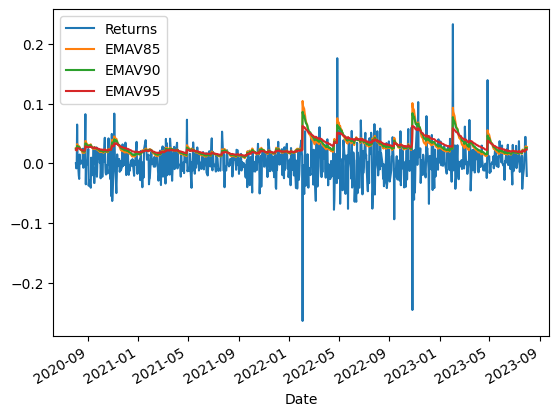

In [8]:
stock[['Returns','EMAV85','EMAV90','EMAV95']].plot()


For low values of lambda EWMA is more reactive to big market events but the high volatility dies quickly.
It is a good idea to check the values by setting lambda close to one. The low values of lambda in a period of low volatility can give you low values of volatility, this value can be misleading. Extreme events can occur in future. The high value of lambda can be used as a limiting case of volatility.

## Binomial Pricing Model

### Variation with volatility

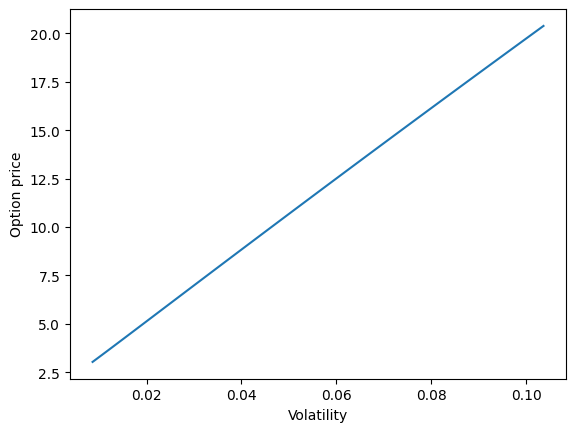

In [9]:
from Option_pricing import Pricing_Models

volatility = stock.EMAV85.values[-1]
# options
current_price = stock.Close[-1]
strike_price = current_price +2
risk_free_rate = 0.05
Expiry = 0.2
dt = 1/252.0
t=0.1


option_price=[]
sigma_range=np.arange(stock.EMAV85.values.min(),stock.EMAV85.values.max(),0.001)
for sigma in sigma_range:
    models = Pricing_Models(strike_price, risk_free_rate, Expiry, sigma,dt)
    option_price.append(models.binomial_pricing(current_price,t))

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Volatility')
ax.set_ylabel(r'Option price')
ax.plot(sigma_range,option_price)

plt.show()


### Variation with time to expiry

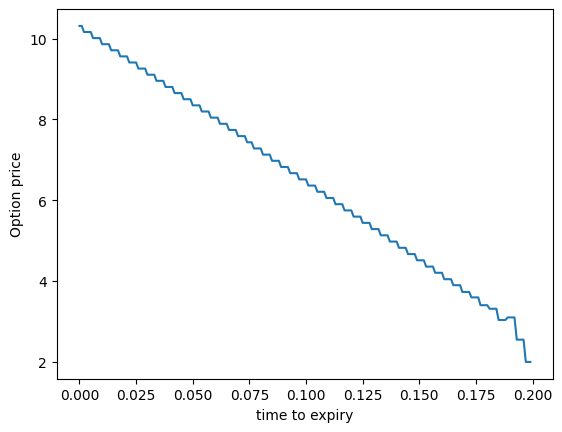

In [10]:
from Option_pricing import Pricing_Models

volatility = stock.EMAV85.values[-1]
# options
current_price = stock.Close[-1]
strike_price = current_price+2
risk_free_rate = 0.05
Expiry = 0.2
dt = 1/252.0

option_price=[]
timetowxp=np.arange(0,Expiry,0.001)
for t in timetowxp:
    models = Pricing_Models(strike_price, risk_free_rate, Expiry, volatility,dt)
    option_price.append(models.binomial_pricing(current_price,t))

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'time to expiry')
ax.set_ylabel(r'Option price')
ax.plot(timetowxp,option_price)

plt.show()


### Variation with date of Expiry

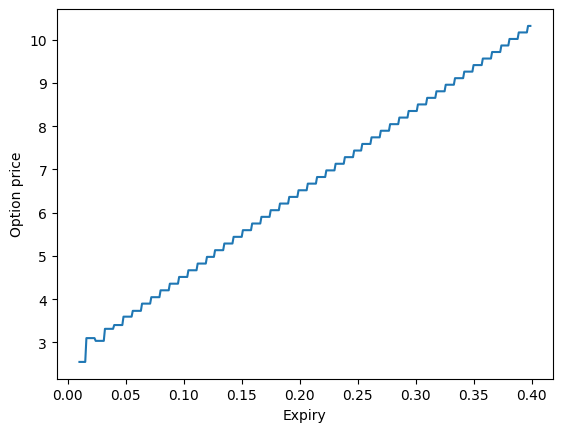

In [11]:
from Option_pricing import Pricing_Models

volatility = stock.EMAV85.values[-1]
# options
current_price = stock.Close[-1]
strike_price = current_price+2
risk_free_rate = 0.05
dt = 1/252.0


option_price=[]
expiry_range=np.arange(0.01,0.4,0.001)
for Expiry in expiry_range:
    t=Expiry/2
    models = Pricing_Models(strike_price, risk_free_rate, Expiry, volatility,dt)
    option_price.append(models.binomial_pricing(current_price,t))

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Expiry')
ax.set_ylabel(r'Option price')
ax.plot(expiry_range,option_price)

plt.show()


## Black-Scholes Model

Black-Scholes option pricing formula for European call options:

$C = S \cdot N(d_1) - X \cdot e^{-rT} \cdot N(d_2)$ 

$P =  X \cdot e^{-rT} \cdot N(-d_2)-S \cdot N(-d_1)$

Where:
- $C$ and $P$ are the call and put options price.
- $S$ is the current stock price.
- $N(d_1)$ is the cumulative standard normal distribution function evaluated at \(d_1\).
- $X$ is the option's strike price.
- $r$ is the risk-free interest rate.
- $T$ is the time to expiration.
- $N(d_2)$ is the cumulative standard normal distribution function evaluated at \(d_2\).

The values of $d_1$ and $d_2$ are calculated as follows:

$d_1 = \frac{\ln(S_0 / X) + (r + \sigma^2 / 2)T}{\sigma\sqrt{T}}$

$d_2 = d_1 - \sigma\sqrt{T}$

This formula is used to calculate the price of a European call option. If you need the formula for a put option, you can use the put-call parity relationship, which relates the prices of European call and put options.

In [12]:
models.Black_Scholes(current_price,t,"call")

2.2193658329368304

For every expiration rate, we will have a range of strike price, their option prices, their last date of trading of that option.

## Option Analysis

In [1]:

import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date


yfin.pdr_override()

def format_date(x):
    return x.strftime('%Y-%m-%d')


# List of stock symbols
ticker = 'META'

import datetime

# Get the current date
current_date = datetime.date.today()

# Calculate the start date one year ago
start_date = current_date - datetime.timedelta(days=365)

# Calculate the end date as today
end_date = current_date

# Download historical stock data for each stock
stock_data = pdr.get_data_yahoo(ticker, start_date, end_date)


expiration = '2023-11-03'
stock_ticker = yfin.Ticker(ticker)
# Fetch options data
options_data = stock_ticker.option_chain(expiration)
# print(options_data.calls['inTheMoney'])
# options_data.calls.plot(x='strike',y='lastPrice')
calls = options_data.calls
puts = options_data.puts

calls['lastTradeDate'] = calls['lastTradeDate'].apply(format_date)
puts['lastTradeDate'] = puts['lastTradeDate'].apply(format_date)


[*********************100%***********************]  1 of 1 completed


(114, 14)

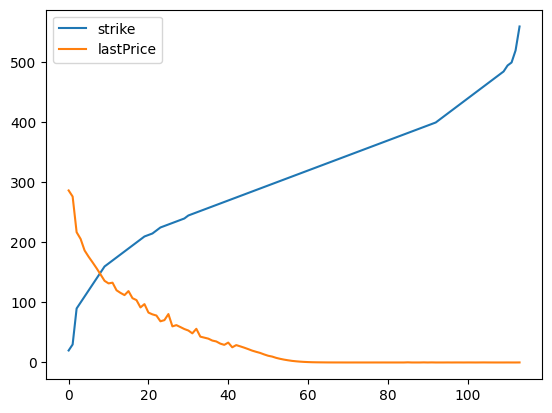

In [3]:
calls[['strike','lastPrice']].plot()

calls.shape

In [74]:
calls.shape

(114, 14)

In [8]:
stock_data

0.44377665324076476

In [5]:
from datetime import datetime
from Option_pricing import Pricing_Models

# get historical volatility
def get_volatility(data, tradedate):
    return data.Close.pct_change().std()*np.sqrt(252)

risk_free_rate = 0.05
deltat = 1/252.0
lastdate = date.today().strftime('%Y-%m-%d')
# iterate over each strike price
strike_price = calls['strike']
volatility = get_volatility(stock_data,tradedate)
            
BS_price = []
op_price=[]
for strike in strike_price:
    strike_df = calls[calls['strike']==strike]
    # print(strike,strike_df.lastTradeDate.values[0])
    
    for tradedate in strike_df['lastTradeDate'].values:
        
        if tradedate != lastdate:

            exp = datetime.strptime(expiration, '%Y-%m-%d')
            tdate = datetime.strptime(tradedate, '%Y-%m-%d')
            Expiry = (exp - tdate).days/252
            deltat = 1.0/252

            model = Pricing_Models(strike,risk_free_rate,Expiry,volatility,deltat)

            stock_price = stock_data.loc[stock_data.index==tradedate,'Close']
            op_price.append(strike_df.loc[strike_df.lastTradeDate==tradedate,'lastPrice'].values[0])
            BS_price.append(model.Black_Scholes(stock_price,"call"))



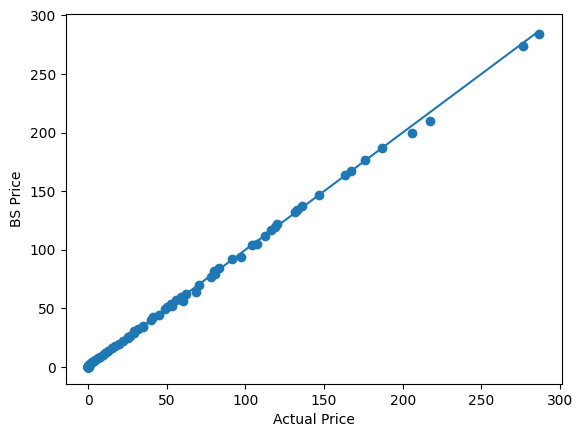

In [8]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Actual Price')
ax.set_ylabel(r'BS Price')
#ax.plot()
#ax.set_xlim()
#ax.set_ylim()

ax.scatter(op_price,BS_price)
ax.plot([min(op_price),max(op_price)],[min(op_price),max(op_price)])

Differences between Black-Scholes option prices and option prices obtained from real market data, like those on Yahoo Finance, are common. There are several reasons for this disparity, including:

- Market Factors: The Black-Scholes model assumes that markets are frictionless, which means there are no transaction costs, no bid-ask spreads, and continuous trading. In reality, these factors can significantly impact option prices.

- Implied Volatility: The Black-Scholes model uses a fixed volatility value. In contrast, market option prices are often determined by implied volatility, which reflects market expectations. Implied volatility can be higher or lower than historical volatility, leading to differences.

- Dividends and Interest Rates: The model assumes constant interest rates and no dividends. In reality, these values can change, affecting option prices.

- Market Supply and Demand: Option prices in the market are influenced by supply and demand, sentiment, and other market dynamics. The Black-Scholes model does not consider these factors.

- Market Liquidity: Liquidity conditions can impact option prices, especially for options with low trading volumes.

- Model Assumptions: The Black-Scholes model has several simplifying assumptions that may not hold in all cases, such as the assumption of log-normal price distributions.



